In [83]:
from IPython.display import HTML

HTML('''
<style>
    .cell.code_cell .input {display: none;}
</style>
''')

# ADDAM clustering : Updates 2024-11-20

We conducted clustering analysis on the 110 samples based on their clinical, genotype, antibody, and ancestry information.

Updates:

* Missing clinical information, i.e. sex, are added to the dataset.
* The ancestry information were added to the dataset by imputation from the genotype data.


Conclusion:

* We first tried simple K-means clustering, and find the clustering was most driven by the genotype profiles, specifically the insulin gene (INS) and the MHC region. The ancestry (specifically the European White ancestry) also played a significant role in the clustering (under pvalue threshold 0.05).


* The HC clustering results are mostly driven driven by MHC region SNPs.


* the FCM clusters are mainly driven by the MHC region and the INS gene.



## Data updates

We added the missing sex and ancestry information for the samples first.

Sex: Among 110 subjects, 58 are male and 52 are female.

Ancestry: Among 110 subjects, 62 are of European ancestry, 39 are of mexican ancestry, and 9 from other populations.

In [ ]:
import pandas as pd
import numpy as np
#first load the data
merged_data = pd.read_csv('results/cluster_Oct_merged.csv')

print(merged_data.shape)

#print the sex distribution
sex_counts = merged_data['Cluster_sex'].value_counts()


(110, 235)


In [ ]:
#load the updated clinical information csv file
clinical_info_updates = pd.read_csv('dat/ADDAM_clustering_MCh_participants_Nov13.csv')

print(clinical_info_updates.shape)

#rename the column name of the 4th column to "sex_birth"
clinical_info_updates.columns.values[3] = "sex_birth"
clinical_info_updates.columns.values[0] = "Subject"

# Print table counts
cluster_sex_counts = clinical_info_updates['sex_birth'].value_counts()

clinical_info_updates = clinical_info_updates[['Subject','sex_birth']]
merged_data_sex = pd.merge(merged_data, clinical_info_updates, on='Subject', how='inner')

merged_data_sex = merged_data_sex.drop(columns = ['Cluster_sex'])
#rename sex_birth to Cluster_sex
merged_data_sex.rename(columns={"sex_birth": "Cluster_sex"}, inplace=True)

#binarize the Cluster_sex to 0 and 1, 0 for female and 1 for male
merged_data_sex['Cluster_sex'] = merged_data_sex["Cluster_sex"].apply(lambda x: 1 if x == "Male" else 0)
print(merged_data_sex['Cluster_sex'].value_counts())

merged_data_sex.to_csv('results/merged_data_sex.csv', index=False)


Cluster_sex
1    58
0    52
Name: count, dtype: int64



The predicted ancestry for the samples are shown in the Figure 1. 
The top three predicted ancestrys in the sample are:

* MXL:	Mexican Ancestry from Los Angeles USA
* TSI:  Toscani in Italia
* CEU: Utah Residents (CEPH) with Northern and Western European Ancestry

Note that the TSI (green) and CEU (blue) are both White European population, therefore we create a new column Ancestry_EUR to represent the European White population. We then coded the ancestry information into 4 columns: Ancestry_MXL, Ancestry_TSI, Ancestry_CEU, Ancestry_EUR. The Ancestry_EUR is created to represent European White population. A sample is assigned value 1 if it is predicted to be from that ancestry, and 0 otherwise. 

Note the ancestry prediction is based on the first two principal components from the genotype data. The prediction is based on the nearest neighbor method using the HapMapIII data as the reference set.

The table counts of the Predicted_Ancestry:
Predicted_Ancestry
MXL    39
TSI    33
CEU    29
GIH     3
JPT     2
CHB     2
YRI     1
LWK     1
Name: count, dtype: int64


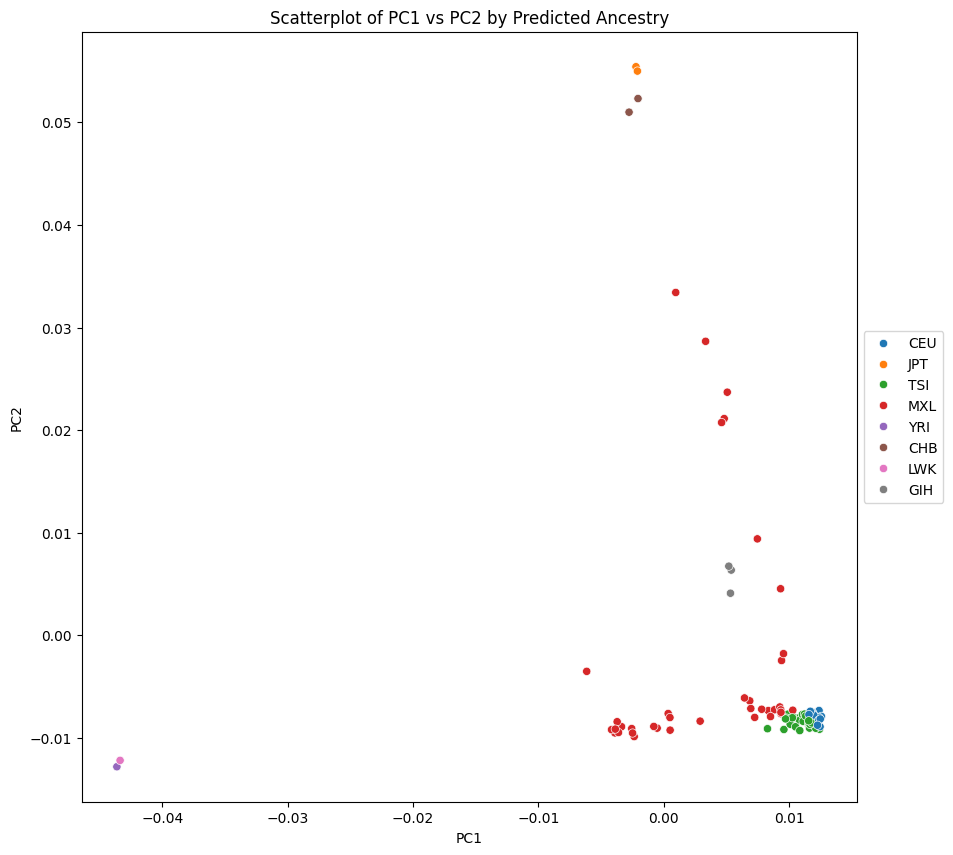

Merged Data Dimensions: (110, 240)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

ancestry_info_updates = pd.read_csv('dat/annotated_ancestry.csv')

subset_ancestry = ancestry_info_updates[ancestry_info_updates['IID'].isin(merged_data_sex['Subject'])].copy()

print("The table counts of the Predicted_Ancestry:")
print(subset_ancestry['Predicted_Ancestry'].value_counts())

plt.figure(figsize=(10, 10))
sns.scatterplot(data=subset_ancestry, x="PC1", y="PC2", hue="Predicted_Ancestry")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Scatterplot of PC1 vs PC2 by Predicted Ancestry')
plt.show()

# Code the ancestry information into 4 columns: Ancestry_MXL, Ancestry_TSI, Ancestry_CEU
ancestry_dict = {'MXL': 'Ancestry_MXL', 'TSI': 'Ancestry_TSI', 'CEU': 'Ancestry_CEU'}
for key, value in ancestry_dict.items():
    subset_ancestry.loc[:, value] = subset_ancestry["Predicted_Ancestry"].apply(lambda x: 1 if x == key else 0)

# Create a new column Ancestry_EUR, which is the sum of Ancestry_TSI and Ancestry_CEU
subset_ancestry.loc[:, 'Ancestry_EUR'] = subset_ancestry['Ancestry_TSI'] + subset_ancestry['Ancestry_CEU']

# Keep only the necessary columns
subset_ancestry = subset_ancestry[['IID', 'Ancestry_MXL', 'Ancestry_EUR', 'Ancestry_TSI', 'Ancestry_CEU']]

merged_data_sex_ancestry = pd.merge(merged_data_sex, subset_ancestry, left_on='Subject', right_on='IID', how='inner')

print("Merged Data Dimensions:", merged_data_sex_ancestry.shape)

merged_data_sex_ancestry.to_csv('results/merged_final_dat_Nov22.csv', index=False)

## Clustering analysis 


We now perform the clustering analysis on the updated profiles of 110 samples based on their clinical, genotype and antibody data. The updated feture list includes:

* patients age (birthdate to date 1 Oct, 2024)
* patients sex (at birth)
* patients ancestry from MXL (yes or no, 1 or 0)
* patients ancestry from TSI (yes or no, 1 or 0)
* patients ancestry from CEU (yes or no, 1 or 0)
* patients ancestry from EUR (yes or no, 1 or 0)
* diabete histories (date of dianosis to date 1 Oct, 2024)
* diabetes in siblings (yes or no, 1 or 0) N = 47
* diabetes in father (1 or 0) N = 38
* diabetes in mother (1 or 0) N = 30
* patients father or mother have diabetes (yes or no, 1 or 0) N = 62
* patients first degree relatives have diabetes AND diabetes in other family members. N = 34
* height
* weight
* insulin dosages
* A1c results in average
* antibody 96GAD Qual (yes or no)
* antibody 96GAD Index (numeric)
* antibody IA2 Qual (yes or no)
* antibody IA2 Index (numeric)
* antibody ZnT8 Qual (yes or no)
* antibody ZnT8 Index (numeric)
*  216 columns of genotype predictors. These columns come from 72 SNPs, while each SNP has 3 columns correspond to three genotype status: 0, 1, 2; corresponding to homozygous, heterozygous, and homozygous respectively.

We conducted clustering analysis on the 110 samples based on their clinical and genotype data. We followed the following steps:

* Preprocess: Standardization of the feature matrix.
* Dimensionality Reduction: Explore PCA and UMAP for dimension reduction and preliminary data cluster patterns.
* Cluster: Apply clustering algorithms (e.g., K-Means and Hierarchical).
* Visualize: Use PCA to visualize the clusters.
* Interpret: Analyze how the clusters relate to clinical and antibody data for insights.
* Note that we first process the data with standardization to ensure that each feature contributes equally to the clustering process.

### PCA Analysis (principal component analysis)

We then conduct PCA to see if we can reduce the dimensionality of the data. The result below shows the top 2 principle components can only explain 10% of the variance. The top 20 principle components can explain 60% of the variance.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

features = merged_data_sex_ancestry.drop(columns=['Subject',"IID"])  # Assuming 'Subject'

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

pd.DataFrame(features_scaled).to_csv('results/scaled_features_Nov.csv', index=False)


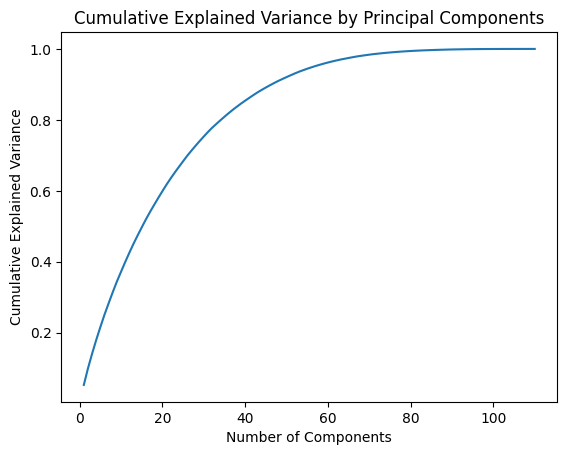

Cumulative explained variance by top 20 components:
[0.053, 0.099, 0.141, 0.18, 0.216, 0.251, 0.283, 0.315, 0.345, 0.372, 0.399, 0.425, 0.45, 0.474, 0.497, 0.519, 0.54, 0.56, 0.58, 0.599]
Number of components required to explain 80% of the variance: 35
Number of components required to explain 90% of the variance: 47


In [ ]:


from sklearn.decomposition import PCA
import seaborn as sns



# calculate the PCA and contribution to variance of each components

pca = PCA()
pca.fit(features_scaled) 
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative proportion of variance explained by each component
cumulative_variance_ratio = explained_variance_ratio.cumsum()
sns.lineplot(x=range(1, len(cumulative_variance_ratio) + 1), y=cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.show()

print("Cumulative explained variance by top 20 components:")
print([round(var, 3) for var in cumulative_variance_ratio[:20]])

n_components = (cumulative_variance_ratio < 0.8).sum() + 1  
print(f"Number of components required to explain 80% of the variance: {n_components}")

n_components = (cumulative_variance_ratio < 0.9).sum() + 1  
print(f"Number of components required to explain 90% of the variance: {n_components}")



### UMAP Analysis (with and without PCA)

Again, we then applied UMAP to the processed data directly to see if we can reduce the dimensionality of the data. However, again, we did not find any clear clustering pattern with UMAP projections.

Specifically, UMAP is a popular non-linear dimension reduction method to reduce data dimensions for a density based clustering algorithm to make progress on. In our practise we manually tuned parameter values of UMAP to explore potential patterns for treatment assignments. For example, we prefer a larger n_neighbors value since small small values will focus more on very local structure and are more prone to producing fine grained cluster structures not fit for treatment assignments. We tried different vaues of n_neighborhoods starting from default 15 to 30. Second it is beneficial to set min_dist to a very low value since we actually want to pack points together densely to making cleaner separations between treatment assignment clusters. We tried different values of min_dist starting from 0.1 to 0.01. We also tried different values of n_components starting from 2 to 3. However, we did not find any clear clustering pattern with UMAP projections. An example of UMAP results is shown below with n_neighbors=15, minimum distance 0.1 and n_componenets 2.

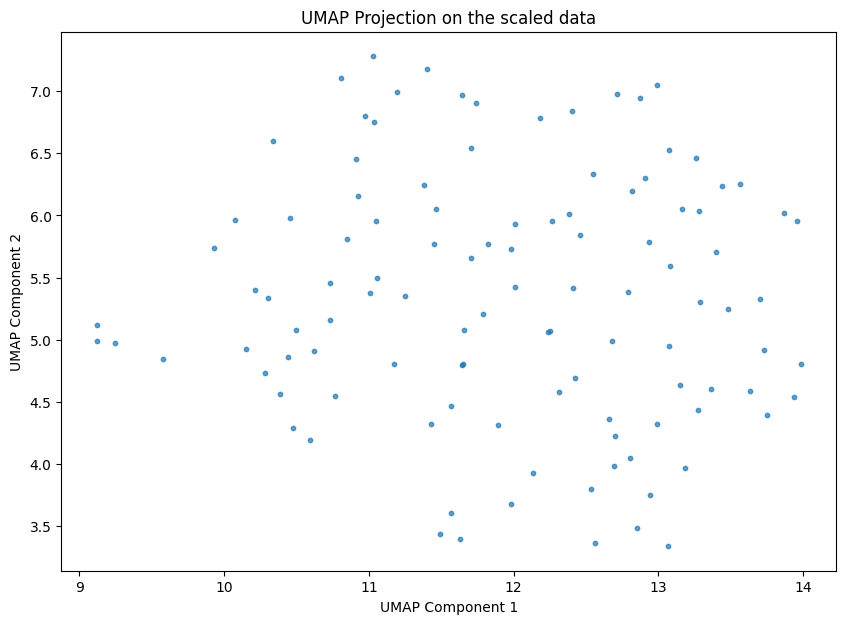

In [ ]:
#conduct UMAP on the scaled features
from umap import UMAP
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")



umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

features_umap = umap.fit_transform(features_scaled)

# Plot UMAP result
plt.figure(figsize=(10, 7))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=10, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection on the scaled data')
plt.show()

### K-means clustering

K-Means Clustering: This is one of the most widely used clustering algorithms. It’s fast and effective for datasets with spherical clusters. We tried both Silhouette and Gap index to evaluate the quality of clusters and choose the optimal number of clusters.

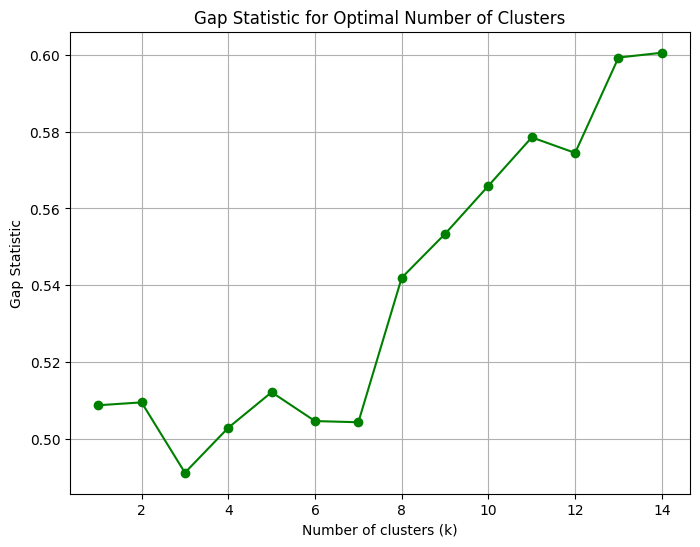

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

def calculate_wcss(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans.inertia_

def compute_gap_statistic(data, k_range, n_reference=10):
    wcss = []  # WCSS for the original dataset
    gap_values = []  # Gap statistic values
    ref_wcss = []  # WCSS for the reference datasets

    # Loop over different values of k
    for k in k_range:
        # Compute WCSS for the actual data
        actual_wcss = calculate_wcss(data, k)
        wcss.append(actual_wcss)

        # Generate WCSS for reference datasets
        ref_wcss_k = []
        for _ in range(n_reference):
            # Generate a random dataset with the same shape as the input data
            random_data = np.random.uniform(low=np.min(data, axis=0),
                                            high=np.max(data, axis=0),
                                            size=data.shape)
            ref_wcss_k.append(calculate_wcss(random_data, k))

        # Calculate the Gap Statistic
        ref_wcss_mean = np.mean(ref_wcss_k)
        ref_wcss.append(ref_wcss_mean)
        gap = np.log(ref_wcss_mean) - np.log(actual_wcss)
        gap_values.append(gap)

    return wcss, ref_wcss, gap_values

K = range(1, 15)  # Range of clusters to evaluate
n_reference = 10  # Number of random reference datasets

wcss, ref_wcss, gap_values = compute_gap_statistic(features_scaled, K, n_reference=n_reference)

plt.figure(figsize=(8, 6))
plt.plot(K, gap_values, 'bo-', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic for Optimal Number of Clusters')
plt.grid(True)
plt.show()


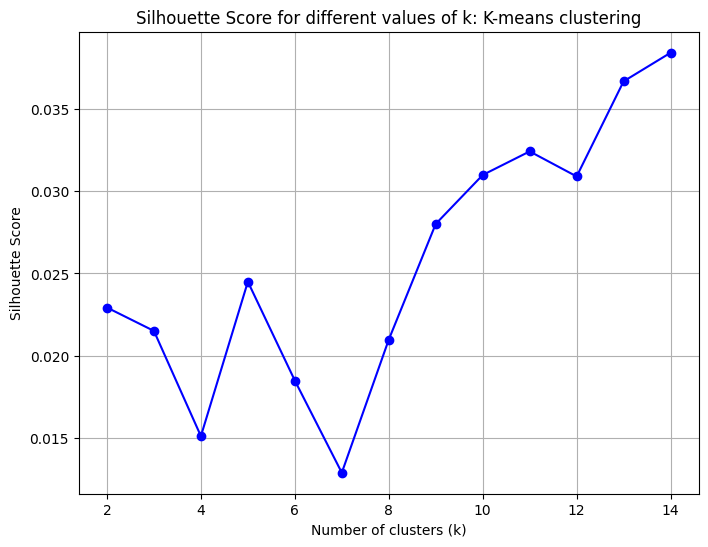

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
K = range(2, 15)  

silhouette_scores = []

for k in K:
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)  
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    
    # Store the silhouette score
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bo-', color='blue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different values of k: K-means clustering')
plt.grid(True)
plt.show()


For Gap Stastistics, the otpimal number of clusters is 2 according to Gap Statistics. 
For Silhouette score, n=5 is slightly better than n=2. 

##### N = 2 Clusters

We first consider n=2 as the optimal number of clusters for K-means clustering. We then visualize the clustering results using PCA.

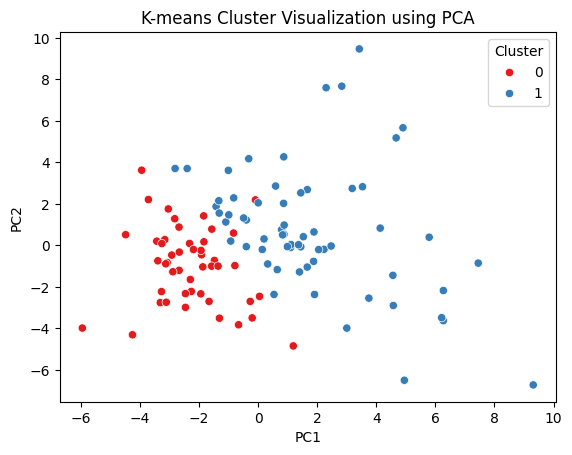

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

optimal_k = 2  #
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(features_scaled)

cluster_labels = cluster_labels_kmeans

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = cluster_labels

sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='Set1')
plt.title('K-means Cluster Visualization using PCA')
plt.show()


The result shows that the first two principal components capture enough of the structure in the data to make the clusters distinguishable. It denotes that the The K-Means clusters align well with the directions of greatest variance (PC1 and PC2).

We then try to interpret and analyze how clusters from K-Means clustering relate to clinical, genotype and antibody data.

For clinical data, we first show summary statistics (e.g., mean) for features within each cluster.

Note that there are interesting differences between the means of the two clusters in the following features: age, weight.

In [ ]:
import pandas as pd


features_columns = features.columns  # Use the original column names from features DataFrame if available


features_genotype = pd.DataFrame(features_scaled[:, :216], columns=features_columns[:216])
features_genotype['Cluster'] = cluster_labels  # Add the cluster labels
#print(features_genotype.columns)

features_clinical = pd.DataFrame(features_scaled, columns=features_columns)  # Recreate DataFrame with original column names
features_clinical = features_clinical.loc[:, features_clinical.columns.str.startswith("Cluster_")]
features_clinical['Cluster'] = cluster_labels


features_antibody = pd.DataFrame(features_scaled[:, 227:233], columns=features_columns[227:233])
features_antibody['Cluster'] = cluster_labels  # Add the cluster labels

features_ancestry = pd.DataFrame(features_scaled[:, 234:], columns=features_columns[234:])
features_ancestry['Cluster'] = cluster_labels  # Add the cluster labels



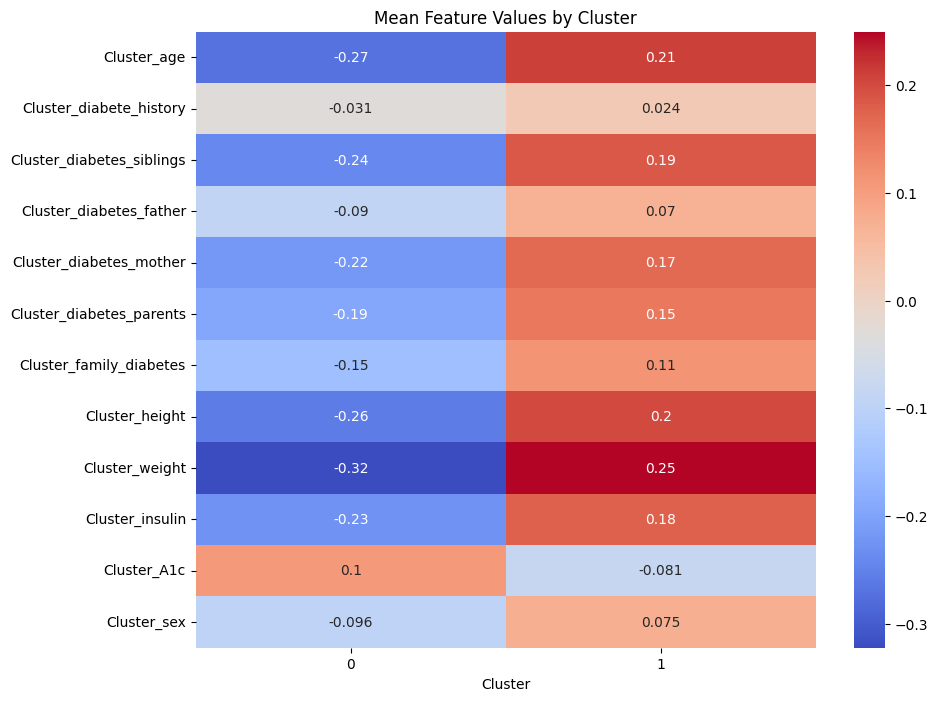

In [ ]:
import seaborn as sns

cluster_summary = features_clinical.groupby('Cluster').mean()




plt.figure(figsize=(10, 8))
sns.heatmap(cluster_summary.T, cmap='coolwarm', annot=True)
plt.title('Mean Feature Values by Cluster')
plt.show()


We then plot the distribution of the age and weight between the two clusters. 

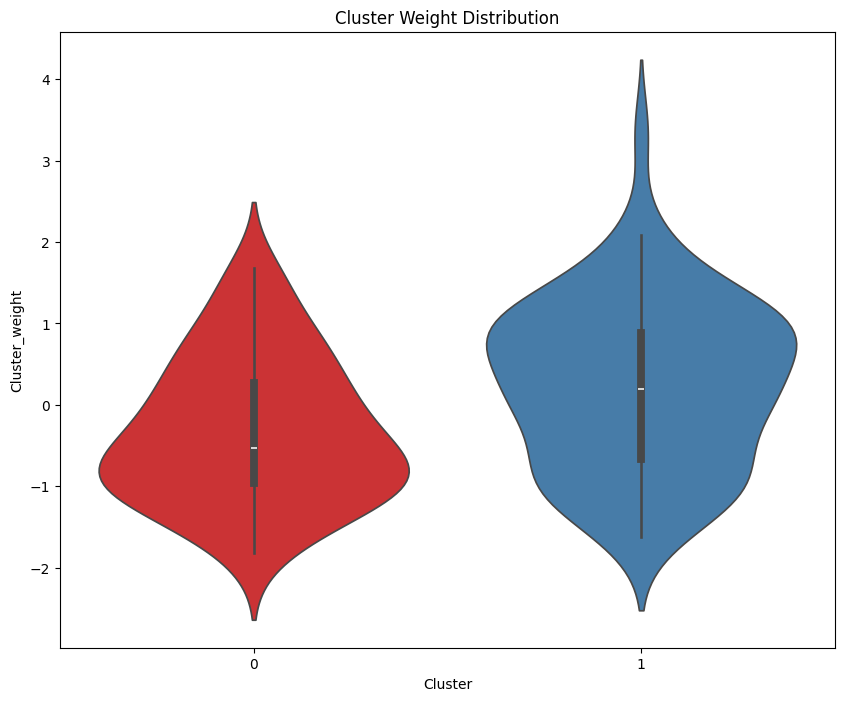

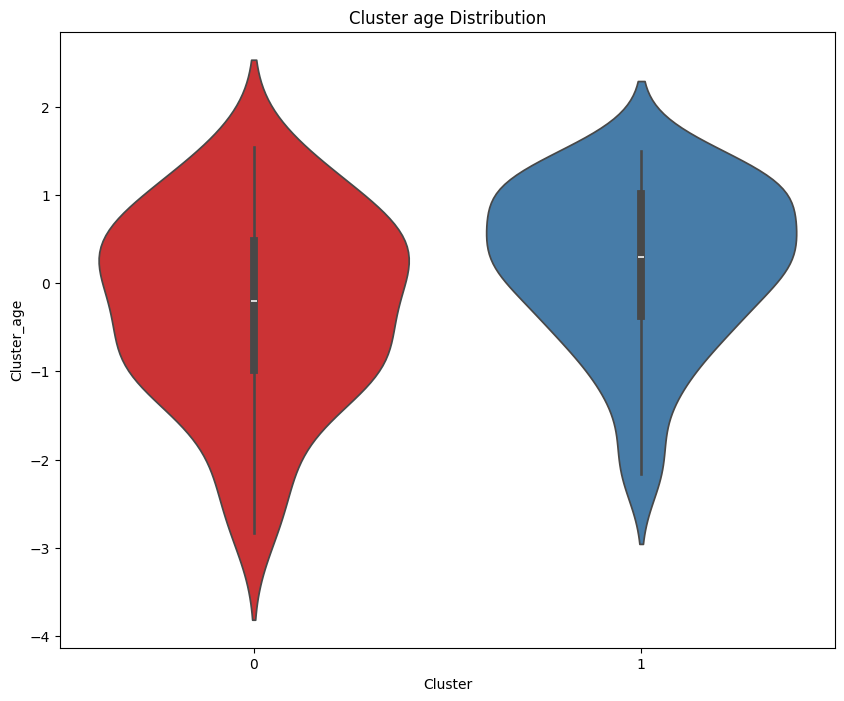

In [ ]:


plt.figure(figsize=(10, 8))
sns.violinplot(x='Cluster', y='Cluster_weight', data=features_clinical, palette='Set1')
plt.title('Cluster Weight Distribution')
plt.show()



      
plt.figure(figsize=(10, 8))
sns.violinplot(x='Cluster', y='Cluster_age', data=features_clinical, palette='Set1')
plt.title('Cluster age Distribution')
plt.show()


We then examine the statistical significance of each feature in the clinical data between clusters. We use ANOVA tests to compare the means of each feature between clusters. 

Note that no clinical features are significant under threshold 0.01 after Bonferroni correction. However, the weight feature have pvalue = 0.03 after Bonferroni correction.


12


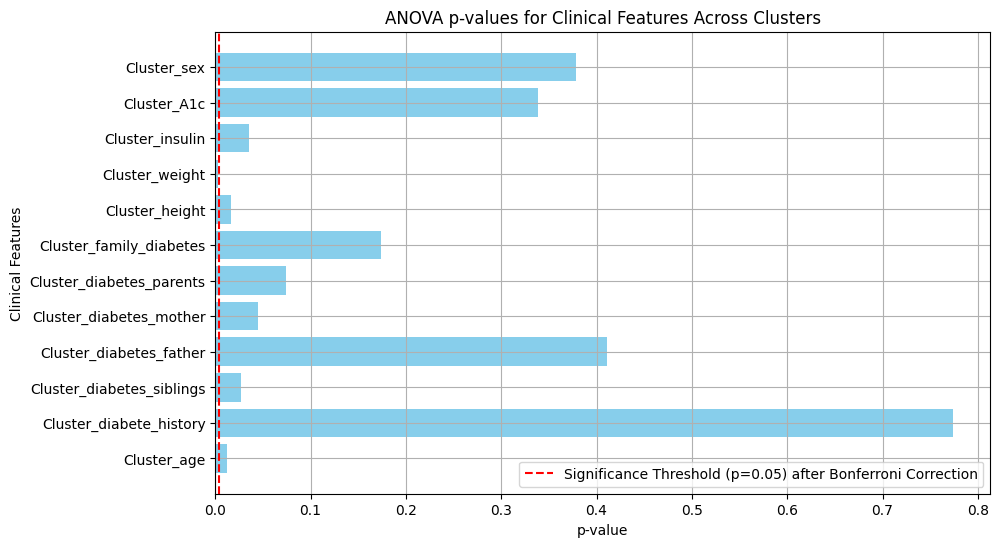

                      Feature   p-value  p-value_Correction
8              Cluster_weight  0.002691            0.032294
0                 Cluster_age  0.011776            0.141312
7              Cluster_height  0.016714            0.200562
2   Cluster_diabetes_siblings  0.026668            0.320019
9             Cluster_insulin  0.035829            0.429943
4     Cluster_diabetes_mother  0.044483            0.533795
5    Cluster_diabetes_parents  0.073923            0.887071
1     Cluster_diabete_history  0.774330            1.000000
3     Cluster_diabetes_father  0.410870            1.000000
6     Cluster_family_diabetes  0.173784            1.000000
10                Cluster_A1c  0.338465            1.000000
11                Cluster_sex  0.378520            1.000000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

clinical_features = features_clinical.drop(columns=['Cluster'])
print(clinical_features.shape[1])
cluster_labels = features_clinical['Cluster']

p_values = []

for column in clinical_features.columns:
    groups = [clinical_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values.append(p_value)

p_values_df = pd.DataFrame({'Feature': clinical_features.columns, 'p-value': p_values})

plt.figure(figsize=(10, 6))
plt.barh(p_values_df['Feature'], p_values_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Clinical Features')
plt.title('ANOVA p-values for Clinical Features Across Clusters')
plt.axvline(x=0.05/clinical_features.shape[1], color='red', linestyle='--', label='Significance Threshold (p=0.05) after Bonferroni Correction')
plt.legend()
plt.grid(True)
plt.show()

p_values_df['p-value_Correction'] = p_values_df['p-value']*12
p_values_df['p-value_Correction'] = p_values_df['p-value_Correction'].apply(lambda x: 1 if x > 1 else x)
print(p_values_df.sort_values(by='p-value_Correction'))


Next, we examine the statistical significance of each feature in the genotype data between clusters. We use ANOVA tests to compare the means of each feature between clusters. The p-values are shown below. Note that the p-values are corrected for multiple testing with Bonferroni correction.

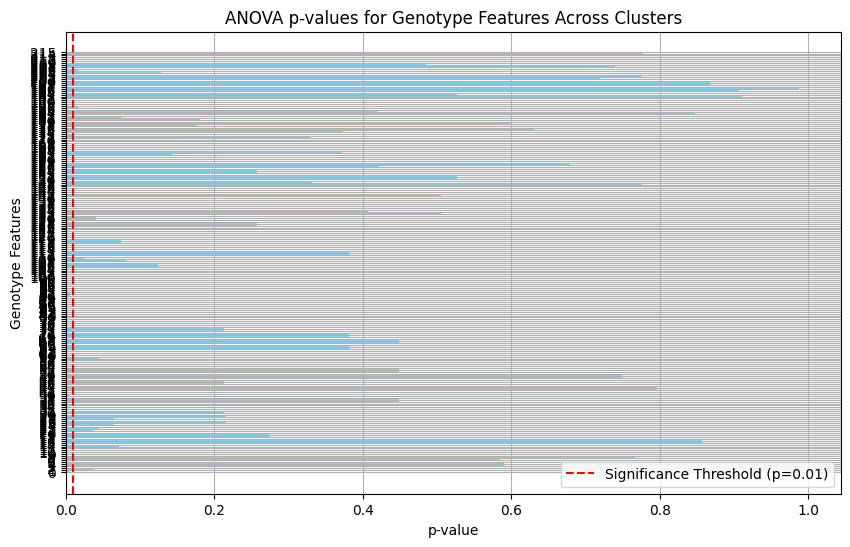

Genotype features with p-value < 0.01 after Bonferroni correction:
60      60
61      61
87      87
88      88
96      96
97      97
160    160
Name: Feature, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

genotype_features = features_genotype.drop(columns=['Cluster'])
cluster_labels = features_genotype['Cluster']

p_values_genotype = []

for column in genotype_features.columns:
    groups = [genotype_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_genotype.append(p_value)

p_values_genotype_df = pd.DataFrame({'Feature': genotype_features.columns, 'p-value': p_values_genotype})

plt.figure(figsize=(10, 6))
plt.barh(p_values_genotype_df['Feature'], p_values_genotype_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Genotype Features')
plt.title('ANOVA p-values for Genotype Features Across Clusters')
plt.axvline(x=0.01, color='red', linestyle='--', label='Significance Threshold (p=0.01)')
plt.legend()
plt.grid(True)
plt.show()

significant_genotype_features = p_values_genotype_df[p_values_genotype_df['p-value'] < 0.01/216]

print("Genotype features with p-value < 0.01 after Bonferroni correction:")
print(significant_genotype_features['Feature'])



Same as we found in the first report, these SNPs corresponds to the features with the most significant p-values in the t-tests:



In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_plink

file_path = 'dat/AM.JDRF.SHARP.fam'


(bim, fam, bed) = pandas_plink.read_plink("dat/AM.JDRF.SHARP")


significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

significant_snps = significant_genotype_features['SNP'].drop_duplicates()

print("Significant SNPs corresponding to p-value < 0.01:")

print(bim.loc[significant_snps - 1])


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 191.92it/s]

Significant SNPs corresponding to p-value < 0.01:
   chrom                snp   cm       pos a0 a1   i
20     6  chr6:32479411:T:A  0.0  32479411  A  T  20
29     6  chr6:32655446:A:C  0.0  32655446  C  A  29
32     6  chr6:32658707:T:C  0.0  32658707  C  T  32
53    11  chr11:2159830:T:G  0.0   2159830  T  G  53


Same as we reported before, these SNPs that are associated with the clusters identified in the K-means clustering analysis are from MHC region and the INS gene.

NOte that the chr11:2159830:T:G is near the INS (insulin) gene, which encodes insulin, a key hormone that regulates glucose metabolism. Variants in and around this gene can be associated with diseases like diabetes, particularly Type 1 diabetes due to its critical role in blood sugar regulation.

Next, we explore the relationship between the clusters and the antibody levels. We first show the p-values from ANOVA test for each feature in the antibody profiles between clusters.

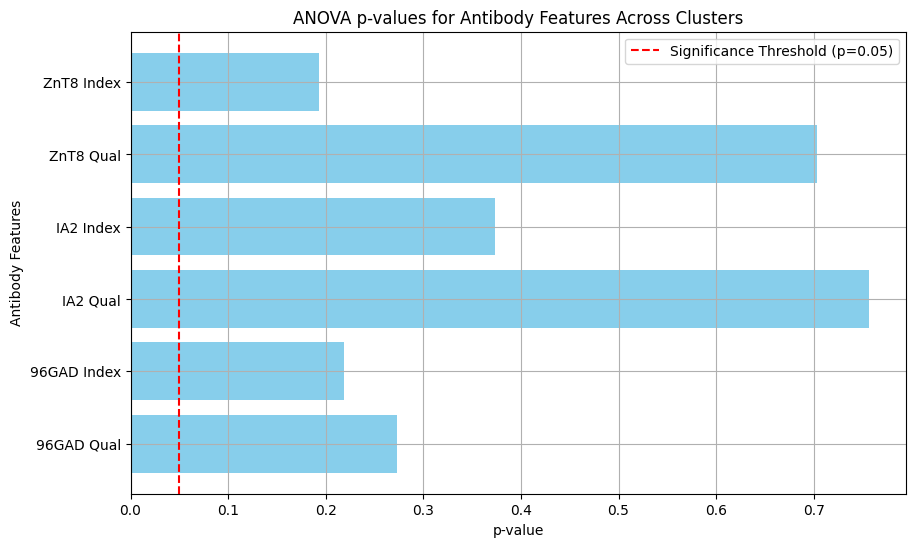

Antibody features with p-value < 0.05:
Series([], Name: Feature, dtype: object)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels = features_antibody['Cluster']

p_values_antibody = []

for column in antibody_features.columns:
    groups = [antibody_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_antibody.append(p_value)

p_values_antibody_df = pd.DataFrame({'Feature': antibody_features.columns, 'p-value': p_values_antibody})

plt.figure(figsize=(10, 6))
plt.barh(p_values_antibody_df['Feature'], p_values_antibody_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Antibody Features')
plt.title('ANOVA p-values for Antibody Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()

significant_antibody_features = p_values_antibody_df[p_values_antibody_df['p-value'] < 0.05]

print("Antibody features with p-value < 0.05:")
print(significant_antibody_features['Feature'])


Note that the associations between the clusters and the antibody levels are not significant.

Finally, we look into the ancestry distribution between two clusters:

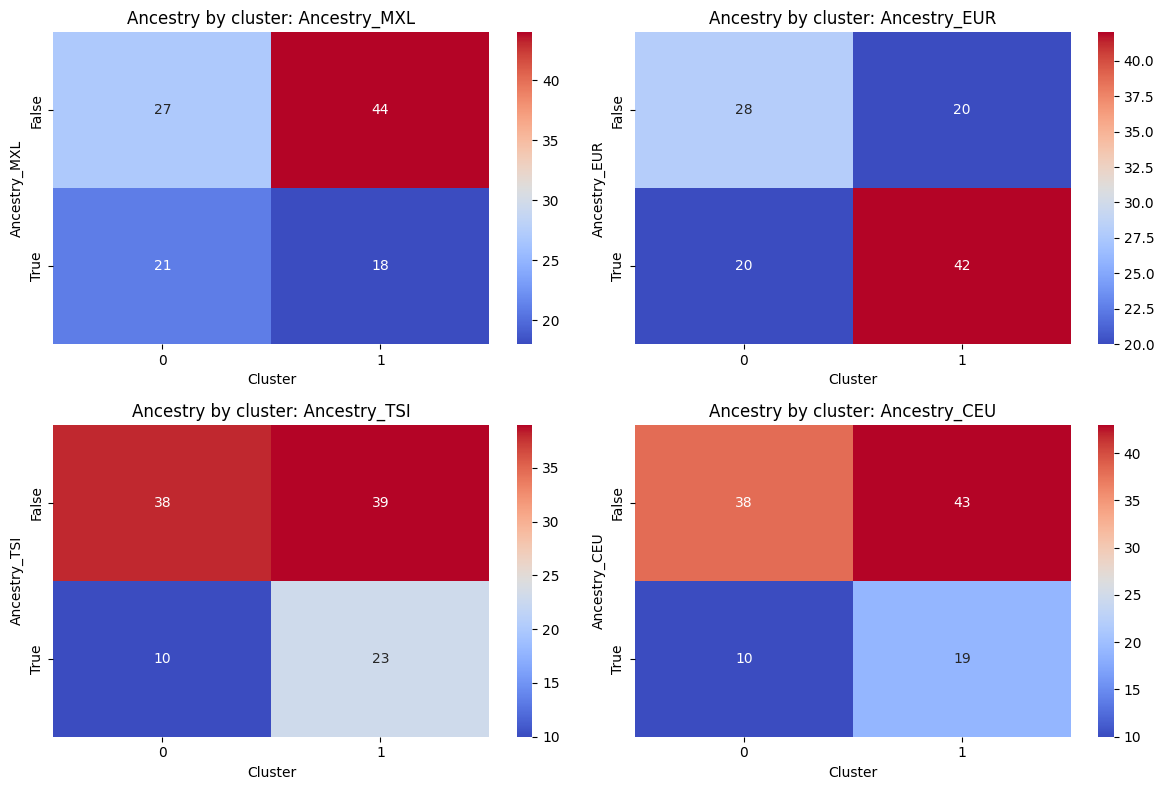


Chi-square Test Results for European ancestry versus clustering labels:
p-value: 0.011


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

ancestry_features = features_ancestry.drop(columns=['Cluster'])
cluster_labels = features_ancestry['Cluster']

contrast_tables = []
for column in ancestry_features.columns:
    contrast_table = pd.crosstab(ancestry_features[column]>0, cluster_labels)
    contrast_tables.append(contrast_table)


    
plt.figure(figsize=(12, 8))
for i, table in enumerate(contrast_tables):
    feature_name = ancestry_features.columns[i]
    plt.subplot(2, 2, i + 1)
    sns.heatmap(table, annot=True, cmap='coolwarm', fmt='d')
    plt.title(f'Ancestry by cluster: {feature_name}')
plt.tight_layout()
plt.show()

contrast_table = contrast_tables[1]


chi2, p_value, dof, expected = chi2_contingency(contrast_table)

print("\nChi-square Test Results for European ancestry versus clustering labels:")
print(f"p-value: {p_value:.3f}")


The result shows that the European White population (Ancestry_EUR) is more likely to be in cluster 1 than cluster 0. The interaction between the ancestry and the clusters is significant under pvalue 0.05 threshold, but not significant under 0.01 threshold.

##### N = 5 Clusters

We then consider n=5 as the optimal number of clusters for K-means clustering. We first visualize the clustering results using PCA.

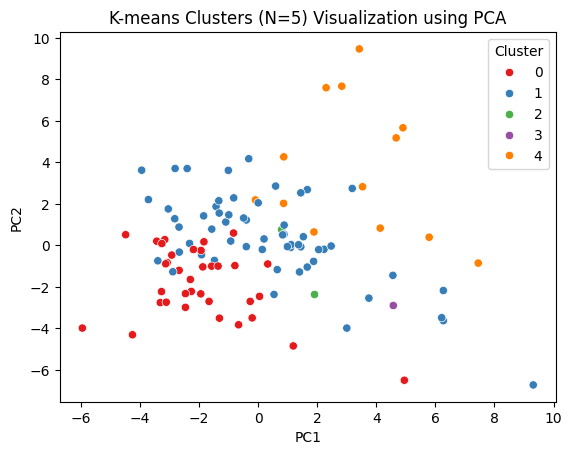

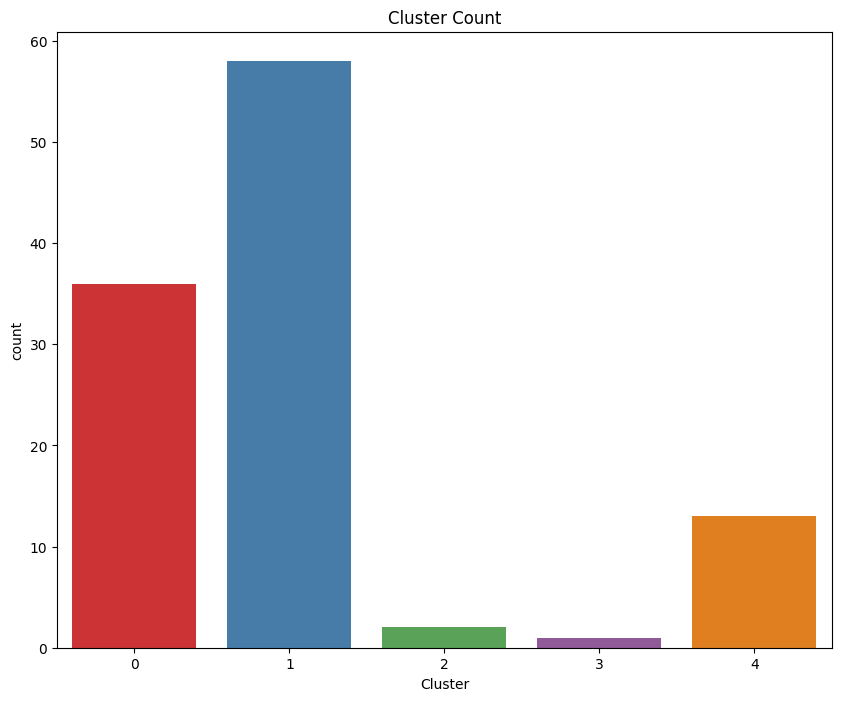

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

optimal_k = 5  #
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(features_scaled)

cluster_labels = cluster_labels_kmeans

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = cluster_labels

sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='Set1')
plt.title('K-means Clusters (N=5) Visualization using PCA')
plt.show()

plt.figure(figsize=(10, 8))
sns.countplot(x='Cluster', data=reduced_df, palette='Set1')
plt.title('Cluster Count')
plt.show()


Next, we examine the statistical significance of each feature across the 5 clusters. We use ANOVA tests to identify significant features that differentiate between 5 clusters. 

The results below show that all the significant features are from SNPs in MHC region. Note that the p-values are corrected for multiple testing with Bonferroni correction.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

cluster_5_features = pd.DataFrame(features_scaled)
cluster_labels = cluster_labels_kmeans

p_values_genotype = []

for column in cluster_5_features.columns:
    groups = [cluster_5_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_genotype.append(p_value)

p_values_genotype_df = pd.DataFrame({'Feature': cluster_5_features.columns, 'p-value': p_values_genotype})


significant_genotype_features = p_values_genotype_df[p_values_genotype_df['p-value'] < 0.01/240]

significant_genotype_features = significant_genotype_features[:-1]

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_plink

file_path = 'dat/AM.JDRF.SHARP.fam'


(bim, fam, bed) = pandas_plink.read_plink("dat/AM.JDRF.SHARP")


# Assuming significant_genotype_features['Feature'] contains the column indices as strings
significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

significant_snps = significant_genotype_features['SNP'].drop_duplicates()

# Print the unique SNPs corresponding to significant genotype features
print("Significant SNPs corresponding to p-value < 0.01: after Bonferroni correction")

print(bim.loc[significant_snps - 1])




Mapping files: 100%|██████████| 3/3 [00:00<00:00, 191.93it/s]

Significant SNPs corresponding to p-value < 0.01: after Bonferroni correction
   chrom                 snp   cm       pos  a0 a1   i
12     6  chr6:31307016:G:GC  0.0  31307016  GC  G  12
20     6   chr6:32479411:T:A  0.0  32479411   A  T  20
29     6   chr6:32655446:A:C  0.0  32655446   C  A  29
30     6   chr6:32658260:G:T  0.0  32658260   T  G  30
32     6   chr6:32658707:T:C  0.0  32658707   C  T  32
33     6   chr6:32659936:G:A  0.0  32659936   A  G  33
35     6   chr6:32704437:G:T  0.0  32704437   T  G  35
36     6   chr6:32705608:C:G  0.0  32705608   G  C  36
37     6   chr6:32706960:C:G  0.0  32706960   G  C  37


In conclusion:

* Under K-means clustering analysis (N = 2), the two clusters was most driven by the genotype profiles, specifically the insulin gene (INS) and the MHC region. The ancestry (specifically the European White ancestry) also played a significant role in the clustering (under pvalue threshold 0.05).

* Under K-means clustering analysis (N=5), the five clusters are solely driven by the MHC region SNPs.


## Hierarchical clustering

We then try the hierarchical clustering and find the optimal number of clusters with the dendrogram.

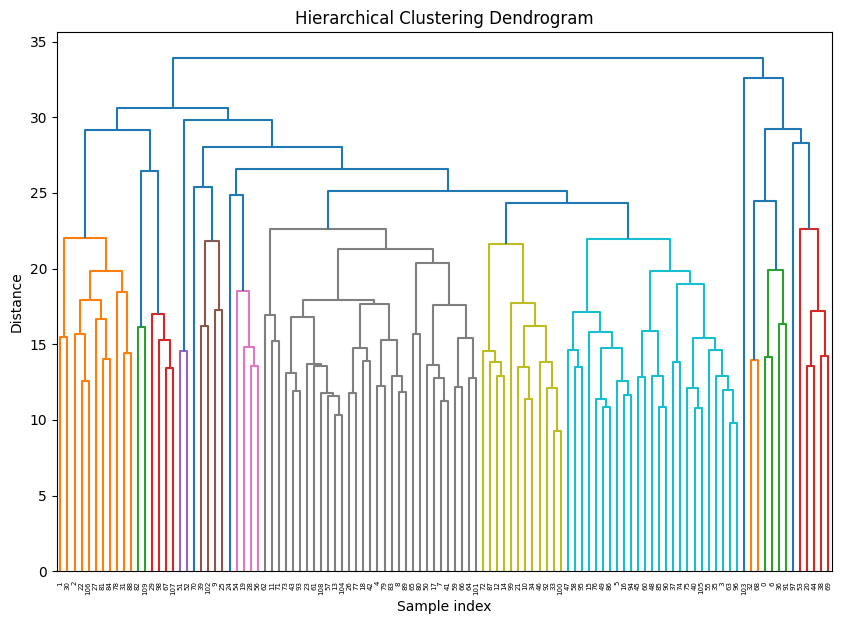

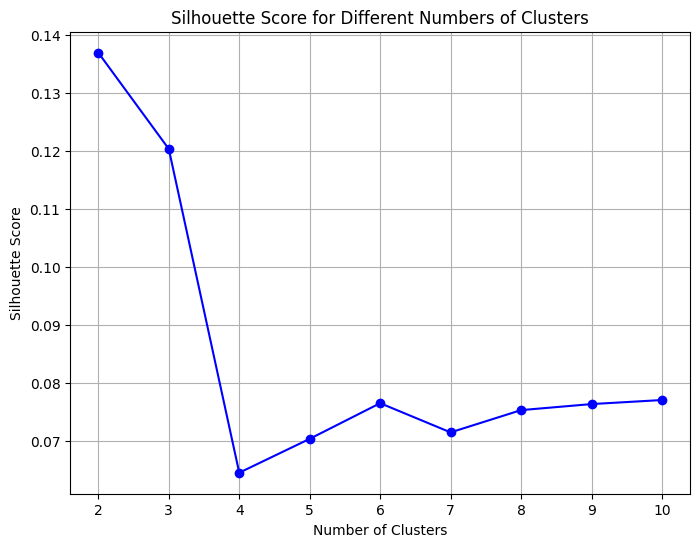

The optimal number of clusters is: 2


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Perform hierarchical clustering using AgglomerativeClustering
linkage_matrix = linkage(features_scaled, method='ward')

# Step 2: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Step 3: Compute Agglomerative Clustering with different numbers of clusters
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative_clustering.fit_predict(features_scaled)

    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Step 4: Plot the silhouette scores for different numbers of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

# Step 5: Identify the optimal number of clusters (maximum silhouette score)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_n_clusters}")


the HC clustering results with PCA components showed that clusters are distinguishable with respect to PCA (Figure below). However, the HC clustering results put only 13 samples (12%) in cluster 1. 

The number of subjects in each cluster:
1    97
0    13
Name: count, dtype: int64


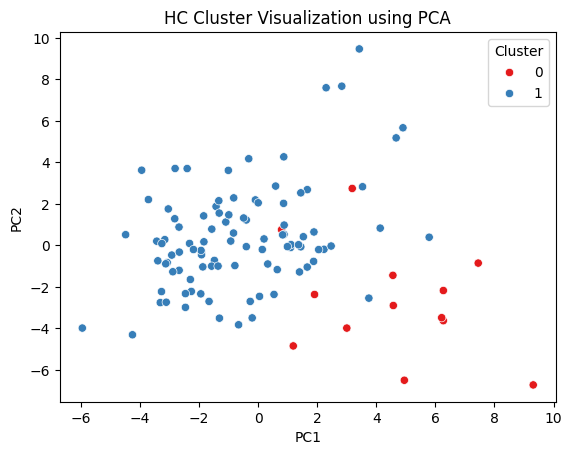

Contingency Table of K-Means and HC Clusters:
HC Clusters       0   1
K-Means Clusters       
0                 2  34
1                 7  51
2                 2   0
3                 1   0
4                 1  12


In [ ]:

# Perform Agglomerative Clustering with the optimal number of clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters=optimal_n_clusters)
cluster_labels_hc = agglomerative_clustering.fit_predict(features_scaled)

print("The number of subjects in each cluster:")
print(pd.Series(cluster_labels_hc).value_counts())


reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = cluster_labels_hc

sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='Set1')
plt.title('HC Cluster Visualization using PCA')
plt.show()

comparison_df = pd.DataFrame({'K-Means Clusters': cluster_labels_kmeans, 'HC Clusters': cluster_labels_hc})
print("Contingency Table of K-Means and HC Clusters:")
print(pd.crosstab(comparison_df['K-Means Clusters'], comparison_df['HC Clusters']))



We then explore the relationship between the HC clusters and the clinical, genotype, and antibody data.

The associations between the clusters and the clinical features are not significant as shown below.

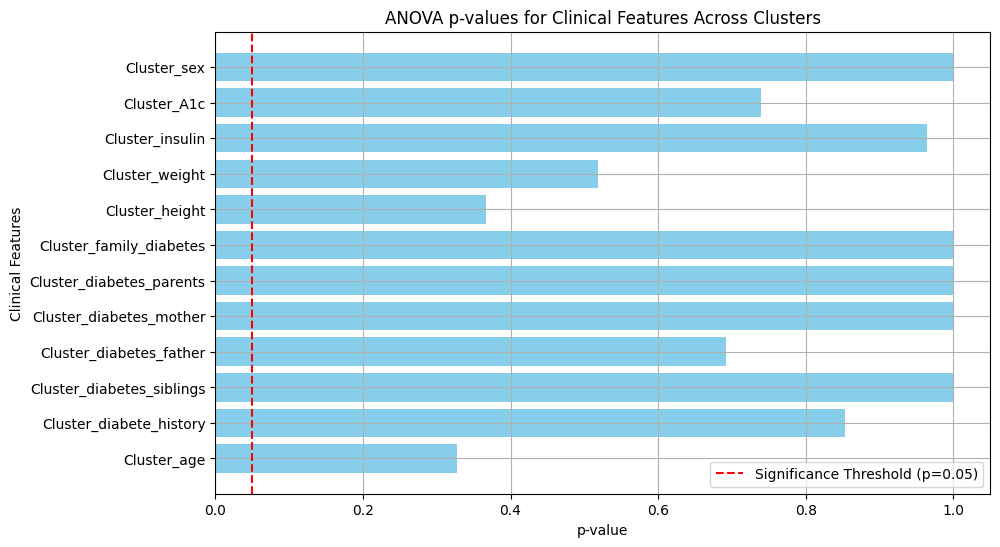

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

clinical_features = features_clinical.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

results = []

for column in clinical_features.columns:
    unique_values = clinical_features[column].nunique()
    
    if unique_values == 2:  # Binary feature
        contingency_table = pd.crosstab(cluster_labels, clinical_features[column])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        results.append({'Feature': column, 'p-value': p_value, 'Test': 'Chi-square'})
    else:  # Continuous feature
        # Perform ANOVA across clusters
        groups = [clinical_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
        _, p_value = f_oneway(*groups)
        results.append({'Feature': column, 'p-value': p_value, 'Test': 'ANOVA'})

p_values_df = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
plt.barh(p_values_df['Feature'], p_values_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Clinical Features')
plt.title('ANOVA p-values for Clinical Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()



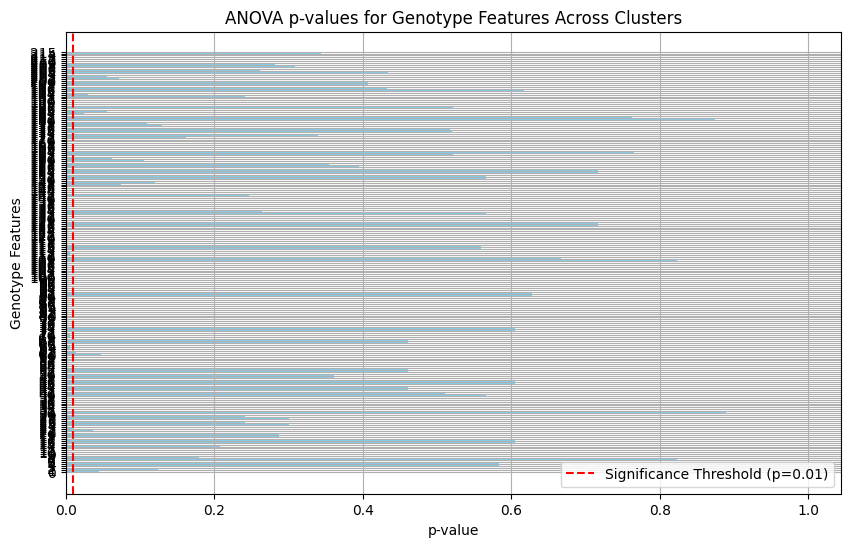

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

genotype_features = features_genotype.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

p_values_genotype = []

for column in genotype_features.columns:
    groups = [genotype_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_genotype.append(p_value)

p_values_genotype_df = pd.DataFrame({'Feature': genotype_features.columns, 'p-value': p_values_genotype})

plt.figure(figsize=(10, 6))
plt.barh(p_values_genotype_df['Feature'], p_values_genotype_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Genotype Features')
plt.title('ANOVA p-values for Genotype Features Across Clusters')
plt.axvline(x=0.01, color='red', linestyle='--', label='Significance Threshold (p=0.01)')
plt.legend()
plt.grid(True)
plt.show()

significant_genotype_features = p_values_genotype_df[p_values_genotype_df['p-value'] < 0.01/216]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

significant_snps = significant_genotype_features['SNP'].drop_duplicates()

print("Significant SNPs corresponding to p-value < 0.01 after Bonferroni correction:")

print(bim.loc[significant_snps - 1])


Significant SNPs corresponding to p-value < 0.01 after Bonferroni correction:
   chrom                 snp   cm       pos  a0 a1   i
12     6  chr6:31307016:G:GC  0.0  31307016  GC  G  12
19     6   chr6:32427740:T:C  0.0  32427740   C  T  19
25     6   chr6:32634974:C:A  0.0  32634974   A  C  25
29     6   chr6:32655446:A:C  0.0  32655446   C  A  29
32     6   chr6:32658707:T:C  0.0  32658707   C  T  32
35     6   chr6:32704437:G:T  0.0  32704437   T  G  35
39     6   chr6:32712215:C:T  0.0  32712215   T  C  39
43     6   chr6:33081532:A:G  0.0  33081532   G  A  43
48     7   chr7:50959497:A:C  0.0  50959497   A  C  48


Apparently, all those significant SNPs are from either (i) the MHC region or (ii) 1 SNP in the region of ENSG00000300692 and ENSG00000228204.

Next, we explore the relationship between the HC clusters and the antibody levels. No significant associations found under pvalue < 0.05 after bonferroni correction. 

       Feature   p-value
0   96GAD Qual  0.459704
1  96GAD Index  0.988507
2     IA2 Qual  0.282069
3    IA2 Index  0.646345
4    ZnT8 Qual  0.380214
5   ZnT8 Index  0.196044


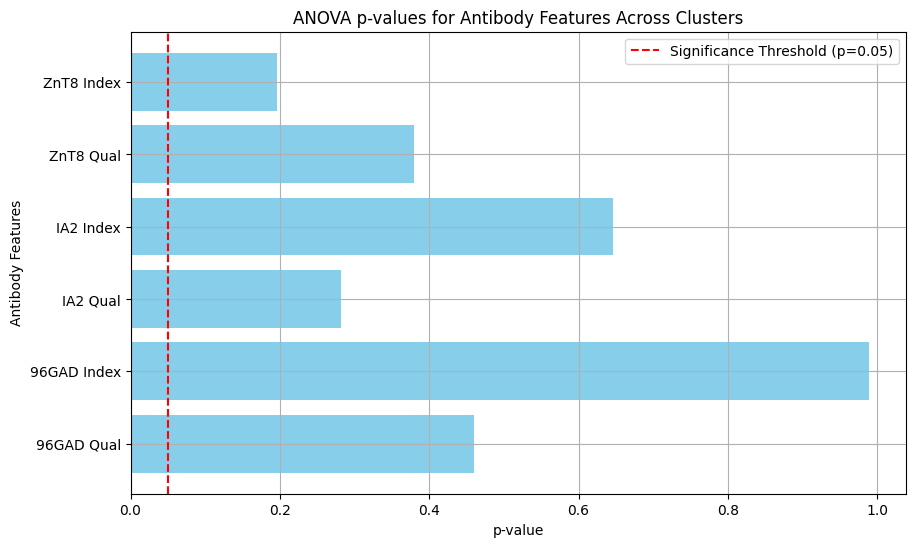

Antibody features with p-value < 0.05:
Series([], Name: Feature, dtype: object)


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

p_values_antibody = []

for column in antibody_features.columns:
    groups = [antibody_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_antibody.append(p_value)

p_values_antibody_df = pd.DataFrame({'Feature': antibody_features.columns, 'p-value': p_values_antibody})

print(p_values_antibody_df)


plt.figure(figsize=(10, 6))
plt.barh(p_values_antibody_df['Feature'], p_values_antibody_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Antibody Features')
plt.title('ANOVA p-values for Antibody Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()

significant_antibody_features = p_values_antibody_df[p_values_antibody_df['p-value'] < 0.05]

print("Antibody features with p-value < 0.05:")
print(significant_antibody_features['Feature'])



    

Finally, we explore the ancestry distribution between two clusters. 

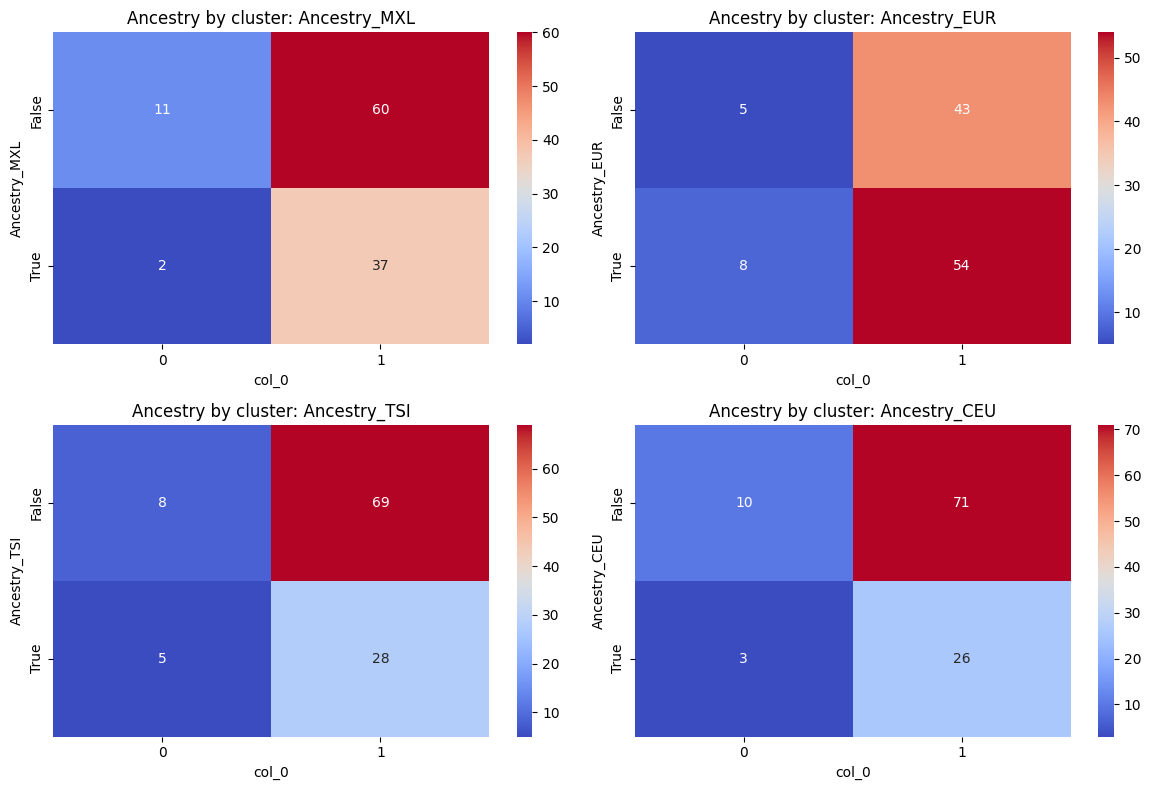


Chi-square Test Results for European ancestry versus clustering labels:
p-value: 0.918. Not significant


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

ancestry_features = features_ancestry.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

contrast_tables = []
for column in ancestry_features.columns:
    contrast_table = pd.crosstab(ancestry_features[column]>0, cluster_labels)
    contrast_tables.append(contrast_table)


    
plt.figure(figsize=(12, 8))
for i, table in enumerate(contrast_tables):
    feature_name = ancestry_features.columns[i]
    plt.subplot(2, 2, i + 1)
    sns.heatmap(table, annot=True, cmap='coolwarm', fmt='d')
    plt.title(f'Ancestry by cluster: {feature_name}')
plt.tight_layout()
plt.show()

contrast_table = contrast_tables[1]


# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contrast_table)

print("\nChi-square Test Results for European ancestry versus clustering labels:")

print(f"p-value: {p_value:.3f}. Not significant")


In conclusion, the HC clustering results mainly seperated a small subset (12%) of patients, driven by MHC region SNPs and CFTR SNP.


###  Soft-threshold Clustering: Fuzzy C-Means Clustering

* Soft Clustering: Instead of assigning each point to a single cluster, FCM computes membership probabilities for each point across all clusters. This is useful when there are no clear boundaries between clusters.

* Membership Matrix: FCM outputs a membership matrix where each data point has a numerical membership value every cluster, instead of categorical clsuter assignments.

* Flexibility: Points that are in overlapping regions between clusters will have high membership in multiple clusters.

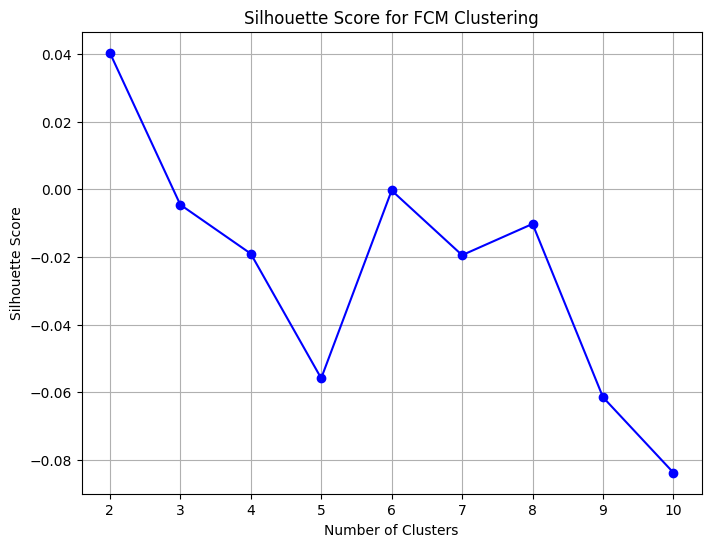

The optimal number of clusters is: 2


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from fcmeans import FCM
from sklearn.metrics import silhouette_score
import pandas as pd

features_scaled_dat = pd.read_csv('results/scaled_features_Nov.csv')

features_scaled = features_scaled_dat.values  # Converts DataFrame to NumPy array



#set a random seed
np.random.seed(42)

range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Step 1: Perform Fuzzy C-Means clustering
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(features_scaled)
    
    # Step 2: Convert soft memberships to hard labels by taking the highest membership value
    fcm_labels = fcm.predict(features_scaled)  # Hard cluster labels
    
    # Step 3: Calculate silhouette score based on hard labels
    silhouette_avg = silhouette_score(features_scaled, fcm_labels)
    silhouette_scores.append(silhouette_avg)

# Step 4: Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for FCM Clustering')
plt.grid(True)
plt.show()

# Step 5: Find the optimal number of clusters (maximum silhouette score)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_n_clusters}")


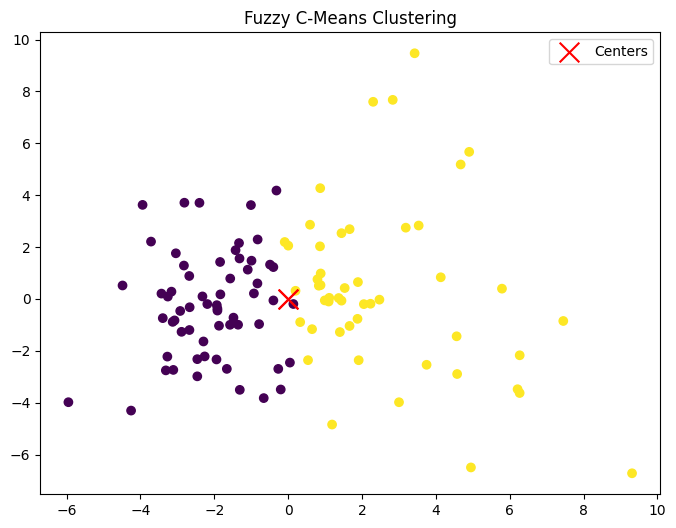

Membership values for first few points:
[[0.49999997 0.50000003]
 [0.49999992 0.50000008]
 [0.49999998 0.50000002]
 [0.50000013 0.49999987]
 [0.50000014 0.49999986]]


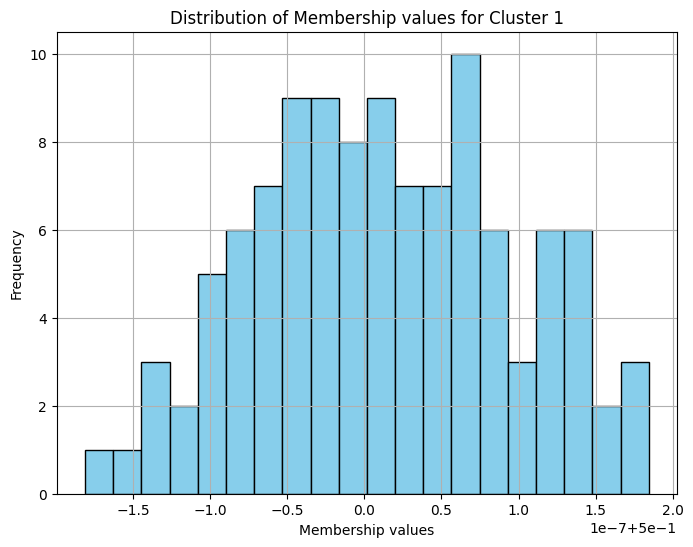

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from fcmeans import FCM
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score


# Set a random seed globally
np.random.seed(42)

n_clusters = 2
best_labels = None
best_membership = None
best_silhouette = -1  # Start with a low silhouette score

# Run FCM multiple times
for _ in range(50):
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(features_scaled)
    fcm_labels = fcm.predict(features_scaled)
    current_membership = fcm.u  # Soft membership matrix
    fcm_centers = fcm.centers
    
    # Calculate silhouette score for evaluation
    silhouette_avg = silhouette_score(features_scaled, fcm_labels)
    
    # Update if this run has the best 
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_labels = fcm_labels
        best_centers = fcm_centers
        best_membership = current_membership

# Assign the best membership matrix
membership_matrix = best_membership
fcm_labels = best_labels
fcm_centers = best_centers

# Step 3: Visualize the clustering using PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=fcm_labels, cmap='viridis')
plt.scatter(fcm_centers[:, 0], fcm_centers[:, 1], marker='x', s=200, color='red', label='Centers')
plt.title('Fuzzy C-Means Clustering')
plt.legend()
plt.show()

print("Membership values for first few points:")
print(membership_matrix[:5])

plt.figure(figsize=(8, 6))
plt.hist(membership_matrix[:, 0], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Membership values')
plt.ylabel('Frequency')
plt.title('Distribution of Membership values for Cluster 1')
plt.grid(True)
plt.show()

#save membership_matrix to /res_cluster/fcm_membership.csv
#pd.DataFrame(membership_matrix).to_csv('results/fcm_membership.csv', index=False)

#now load membershiup_matrix from /res_cluster/fcm_membership.csv
#membership_matrix = pd.read_csv('results/fcm_membership.csv').values


In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)
clinical_features = features_clinical.drop(columns=['Cluster'])
cluster_labels_fcm = membership_matrix[:, 0]


p_values = []
r_squared = []

for column in clinical_features.columns:
    X = sm.add_constant(clinical_features[column])  # Add a constant (intercept term)
    model = sm.OLS(cluster_labels_fcm, X).fit()  # Fit the linear regression model
    p_values.append(model.pvalues[1])  # Store the p-value of the feature
    r_squared.append(model.rsquared)  # Store the R-squared value

regression_results = pd.DataFrame({
    'Feature': clinical_features.columns,
    'p-value': p_values,
    'R-squared': r_squared
})

print(regression_results)


                      Feature   p-value  R-squared
0                 Cluster_age  0.022800   0.047075
1     Cluster_diabete_history  0.202780   0.014977
2   Cluster_diabetes_siblings  0.914243   0.000108
3     Cluster_diabetes_father  0.518978   0.003862
4     Cluster_diabetes_mother  0.648369   0.001933
5    Cluster_diabetes_parents  0.604533   0.002492
6     Cluster_family_diabetes  0.739209   0.001030
7              Cluster_height  0.041788   0.037812
8              Cluster_weight  0.007068   0.065265
9             Cluster_insulin  0.011933   0.057100
10                Cluster_A1c  0.684501   0.001535
11                Cluster_sex  0.808082   0.000549


The associations between the FCM clusters and the clinical features are not sigificant under pvalue < 0.05 after bonferroni correction.

Next, we explore the relationship between the FCM clusters and the genotype data. We first show the genotype features with significant p-values under 0.05 after Bonferroni correction for multiple testing.

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)

genotype_features = features_genotype.drop(columns=['Cluster'])
cluster_labels_fcm = membership_matrix[:, 0]


p_values = []
r_squared = []

for column in genotype_features.columns:
    X = sm.add_constant(genotype_features[column])  # Add a constant (intercept term)
    model = sm.OLS(cluster_labels_fcm, X).fit()  # Fit the linear regression model
    p_values.append(model.pvalues[1])  # Store the p-value of the feature
    r_squared.append(model.rsquared)  # Store the R-squared value

regression_results = pd.DataFrame({
    'Feature': genotype_features.columns,
    'p-value': p_values,
    'R-squared': r_squared
})

print("Genotype features with p-value < 0.05 after Bonferroni correction for multiple testing:")
print(regression_results[regression_results['p-value'] < 0.05/216])

significant_genotype_features = regression_results[regression_results['p-value'] < 0.05/216]


Genotype features with p-value < 0.05 after Bonferroni correction for multiple testing:
    Feature       p-value  R-squared
60       60  4.049166e-10   0.304806
61       61  2.298062e-13   0.393305
87       87  3.145599e-13   0.389816
88       88  1.648334e-23   0.604833
90       90  3.786926e-07   0.213352
91       91  3.786926e-07   0.213352
96       96  3.145599e-13   0.389816
97       97  1.648334e-23   0.604833
99       99  3.786926e-07   0.213352
100     100  3.786926e-07   0.213352
114     114  1.311112e-05   0.161950
115     115  1.311112e-05   0.161950
159     159  2.233554e-08   0.252441
160     160  1.878531e-10   0.314436


In [ ]:
import warnings
warnings.filterwarnings("ignore")

significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

significant_snps = significant_genotype_features['SNP'].drop_duplicates()

print("Significant SNPs corresponding to p-value < 0.05 after Bonfferoni correction:")
print(significant_snps)

print(bim.loc[significant_snps - 1])


Significant SNPs corresponding to p-value < 0.05 after Bonfferoni correction:
60     21
87     30
90     31
96     33
99     34
114    39
159    54
Name: SNP, dtype: int64
   chrom                snp   cm       pos a0 a1   i
20     6  chr6:32479411:T:A  0.0  32479411  A  T  20
29     6  chr6:32655446:A:C  0.0  32655446  C  A  29
30     6  chr6:32658260:G:T  0.0  32658260  T  G  30
32     6  chr6:32658707:T:C  0.0  32658707  C  T  32
33     6  chr6:32659936:G:A  0.0  32659936  A  G  33
38     6  chr6:32709663:G:A  0.0  32709663  A  G  38
53    11  chr11:2159830:T:G  0.0   2159830  T  G  53


The markers that are associated with the FCM clusters are from the MHC region and the INS (insulin) gene on chromosome 11. The INS gene is highly significant because it encodes insulin.

Next, we explore the relationship between the FCM clusters and the antibody levels. 

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels_fcm = membership_matrix[:, 0]


p_values = []
r_squared = []

for column in antibody_features.columns:
    X = sm.add_constant(antibody_features[column])  # Add a constant (intercept term)
    model = sm.OLS(cluster_labels_fcm, X).fit()  # Fit the linear regression model
    p_values.append(model.pvalues[1])  # Store the p-value of the feature
    r_squared.append(model.rsquared)  # Store the R-squared value

regression_results = pd.DataFrame({
    'Feature': antibody_features.columns,
    'p-value: before Correction': p_values,
    'R-squared': r_squared
})

print(regression_results)


       Feature  p-value: before Correction  R-squared
0   96GAD Qual                    0.078562   0.028374
1  96GAD Index                    0.223510   0.013688
2     IA2 Qual                    0.768813   0.000803
3    IA2 Index                    0.064940   0.031191
4    ZnT8 Qual                    0.586482   0.002748
5   ZnT8 Index                    0.009204   0.061144


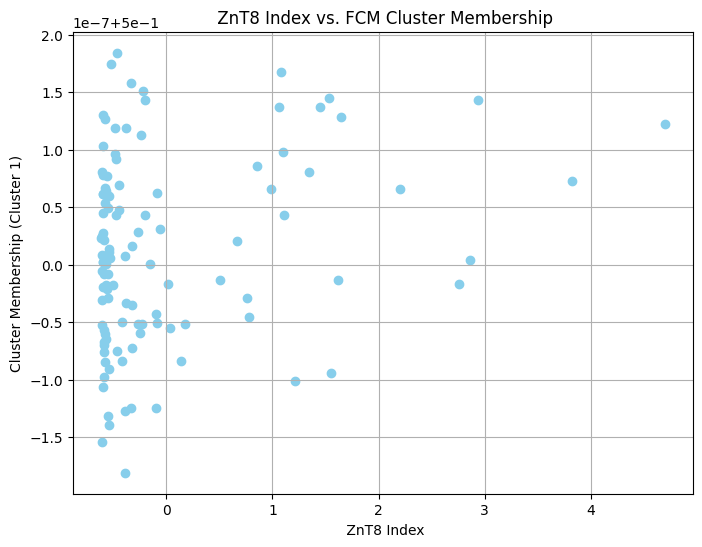

In [116]:
#we draw the scatterplot of the ZnT8 Index  versus the cluster_labels_fcm
plt.figure(figsize=(8, 6))
plt.scatter(features_antibody['ZnT8 Index'], cluster_labels_fcm, color='skyblue')
plt.xlabel(' ZnT8 Index')
plt.ylabel('Cluster Membership (Cluster 1)')
plt.title(' ZnT8 Index vs. FCM Cluster Membership')
plt.grid(True)
plt.show()




Finally, we explore the ancestry distribution by cluster memberships.

In [ ]:
from scipy.stats import ttest_ind

results = []



for column in ancestry_features.columns:
    group_1 = cluster_labels[ancestry_features[column] > 0 ]
    group_0 = cluster_labels[ancestry_features[column] < 0]
    
    # Perform the t-test
    t_stat, p_value = ttest_ind(group_1, group_0, equal_var=False)  # Welch's t-test
    results.append({'Feature': column, 'T-statistic': t_stat, 'P-value': p_value})

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='P-value').reset_index(drop=True)

print(results_df)

        Feature  T-statistic  P-value before correction
0  Ancestry_MXL     1.846526                   0.067590
1  Ancestry_TSI    -0.657677                   0.513622
2  Ancestry_EUR    -0.401906                   0.688570
3  Ancestry_CEU     0.292945                   0.770720


In conclusion, the FCM clusters are mainly driven by the MHC region, the INS gene.